In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import numpy as np
import shutil
import torch
import random
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset,DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
trainset="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
testset="/kaggle/input/chest-xray-pneumonia/chest_xray/test"

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), ( 0.5))
])
batch_size = 32

In [4]:
def create_balanced_dataset(source_dir, target_dir, class1, class2):    
    class1_dir = os.path.join(source_dir, class1)
    class2_dir = os.path.join(source_dir, class2)    
    class1_images = os.listdir(class1_dir)
    class2_images = os.listdir(class2_dir)
        
    num_samples = min(len(class1_images), len(class2_images))    
    sampled_class1_images = random.sample(class1_images, num_samples)
    sampled_class2_images = random.sample(class2_images, num_samples)
        
    target_class1_dir = os.path.join(target_dir, class1)
    target_class2_dir = os.path.join(target_dir, class2)
    os.makedirs(target_class1_dir, exist_ok=True)
    os.makedirs(target_class2_dir, exist_ok=True)
        
    for img in sampled_class1_images:
        shutil.copy(os.path.join(class1_dir, img), target_class1_dir)    
    for img in sampled_class2_images:
        shutil.copy(os.path.join(class2_dir, img), target_class2_dir)    
    print(f"Balanced dataset created with {num_samples} images in each class.")
    
source_directory = trainset
sr2 = testset
target_directory = '/kaggle/working/chest-xray-pneumonia/train'
tr2 = '/kaggle/working/chest-xray-pneumonia/test'
create_balanced_dataset(source_directory, target_directory, 'NORMAL', 'PNEUMONIA')
create_balanced_dataset(sr2, tr2, 'NORMAL', 'PNEUMONIA')

Balanced dataset created with 1341 images in each class.
Balanced dataset created with 234 images in each class.


In [5]:
trs='/kaggle/working/chest-xray-pneumonia/train/PNEUMONIA/'
tn='/kaggle/working/chest-xray-pneumonia/train/NORMAL/'
ts1='/kaggle/working/chest-xray-pneumonia/test/PNEUMONIA/'
ts2='/kaggle/working/chest-xray-pneumonia/test/NORMAL/'

newtrain='/kaggle/working/chest-xray-pneumonia/train'
newtest='/kaggle/working/chest-xray-pneumonia/test'

In [6]:
def count_images(directory):    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}    
    image_count = sum(1 for file in os.listdir(directory) if os.path.splitext(file)[1].lower() in image_extensions)
    print(f"Number of images in '{directory}': {image_count}")
    return image_count

count_images(trs)
count_images(tn)
count_images(ts1)
count_images(ts2)

Number of images in '/kaggle/working/chest-xray-pneumonia/train/PNEUMONIA/': 1341
Number of images in '/kaggle/working/chest-xray-pneumonia/train/NORMAL/': 1341
Number of images in '/kaggle/working/chest-xray-pneumonia/test/PNEUMONIA/': 234
Number of images in '/kaggle/working/chest-xray-pneumonia/test/NORMAL/': 234


234

In [7]:
traindata=torchvision.datasets.ImageFolder(newtrain,transform=transform)
testdata=torchvision.datasets.ImageFolder(newtest,transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=True, num_workers=2)

clas=traindata.classes
print(clas)
print(f"Dataloaders: {trainloader ,testloader}")
print(f"Length of train dataloader: {len(trainloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(testloader)} batches of {batch_size}")

['NORMAL', 'PNEUMONIA']
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e73a7bebcd0>, <torch.utils.data.dataloader.DataLoader object at 0x7e73aace1db0>)
Length of train dataloader: 84 batches of 32
Length of test dataloader: 15 batches of 32


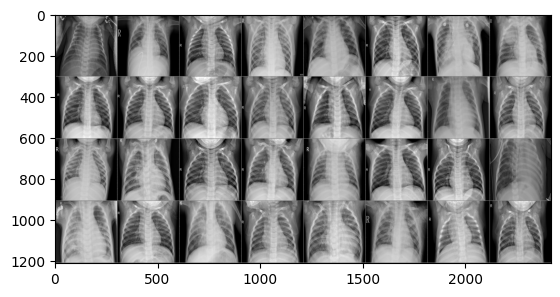

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [9]:
img, label = next(iter(trainloader))
img = img.to(device)
label = label.to(device)
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 300, 300]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [10]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):

    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [11]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [12]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,  optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)        
        test_loss, test_acc = test_step(model=model, dataloader=testloader, loss_fn=loss_fn)

        print(f"Epoch: {epoch+1} | " f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "f"test_loss: {test_loss:.4f} | " f"test_acc: {test_acc:.4f}" )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)            
    return results

In [13]:
!pip install timm
import torch
import torch.nn as nn
import timm 

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        # Load pre-trained Xception model
        self.feature_extractor = timm.create_model('xception', pretrained=True, num_classes=0)  # num_classes=0 removes the classifier
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),  # Xception outputs 2048 features
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features with Xception
        x = self.classifier(x)  # Pass through the custom classifier
        return x

In [15]:
net = Net().to(device)
NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
start_time = timer()

model_results = train(model=net, train_dataloader=trainloader,test_dataloader=testloader,
                      optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2189 | train_acc: 0.9113 | test_loss: 0.3305 | test_acc: 0.8704
Epoch: 2 | train_loss: 0.0851 | train_acc: 0.9691 | test_loss: 1.4931 | test_acc: 0.7204
Epoch: 3 | train_loss: 0.1093 | train_acc: 0.9719 | test_loss: 1.4877 | test_acc: 0.8229
Epoch: 4 | train_loss: 0.0793 | train_acc: 0.9784 | test_loss: 0.7656 | test_acc: 0.8346
Epoch: 5 | train_loss: 0.0321 | train_acc: 0.9881 | test_loss: 3.5343 | test_acc: 0.7875
Epoch: 6 | train_loss: 0.0571 | train_acc: 0.9829 | test_loss: 0.9471 | test_acc: 0.8250
Epoch: 7 | train_loss: 0.0237 | train_acc: 0.9918 | test_loss: 0.9920 | test_acc: 0.7863
Epoch: 8 | train_loss: 0.0134 | train_acc: 0.9963 | test_loss: 2.2153 | test_acc: 0.7079
Epoch: 9 | train_loss: 0.0275 | train_acc: 0.9896 | test_loss: 1.4339 | test_acc: 0.8050
Epoch: 10 | train_loss: 0.0233 | train_acc: 0.9933 | test_loss: 0.8546 | test_acc: 0.8008
Total training time: 818.968 seconds


In [16]:
def plot_loss_curves(results):
    results = dict(list(model_results.items()))
    loss = results['train_loss']
    test_loss = results['test_loss']        
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

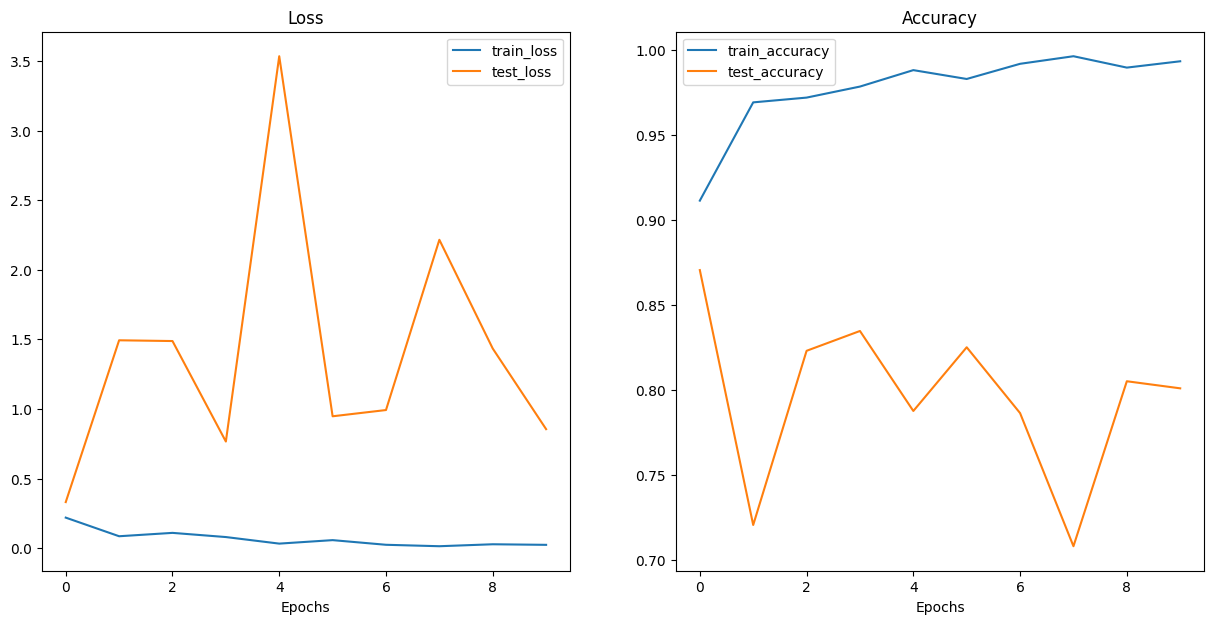

In [17]:
plot_loss_curves(model_results)